In [37]:
!pip install scikit-learn

/Users/mohamedmentis/.zshenv:.:1: no such file or directory: /Users/mohamedmentis/.cargo/env
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/cd/7a/19fe32c810c5ceddafcfda16276d98df299c8649e24e84d4f00df4a91e01/scikit_learn-1.5.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached scikit_learn-1.5.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (13 kB)
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp31

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [121]:
df=pd.read_csv("../data/dairy_cows.csv")
df=df.drop(['ID'], axis=1)
df.head()

,Species,Animal_Class,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Ease,Indicator_Resources
0,Dairy cows,Tie stalls,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low
1,Dairy cows,Cubicles,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low
2,Dairy cows,Tie stalls,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low
3,Dairy cows,Cubicles,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low
4,Dairy cows,Tie stalls,Insufficient space,Restriction of movement,High,Moderate,Agonistic interactions,Moderate,Medium


In [122]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Fit and transform the 'Welfare_Indicator' column
X_encoded = encoder.fit_transform(df[['Welfare_Indicator']]).toarray()

# Get the feature names
indicator_names = encoder.get_feature_names_out(['Welfare_Indicator'])

# Print shapes for debugging
print("Shape of X_encoded:", X_encoded.shape)
print("Number of indicator_names:", len(indicator_names))


Shape of X_encoded: (388, 53)
Number of indicator_names: 53


## Lasso

In [123]:
import pandas as pd

# Assuming X_encoded is the encoded array
X = pd.DataFrame(X_encoded, columns=indicator_names)

# Define target variable
y = df['Welfare_Hazards_Impact'].map({'High': 1, 'Low': 0})  # Encode ordinally

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply LASSO for feature selection
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Coefficients
coef = pd.Series(lasso.coef_, index=X.columns)
important_features = coef[coef != 0].sort_values()

print("Selected Indicators by LASSO:")
print(important_features)


Selected Indicators by LASSO:
Welfare_Indicator_Time budgets (disruption of behaviour)                                                                                                           -0.993797
Welfare_Indicator_Time budgets (prevention of behaviour)                                                                                                           -0.992814
Welfare_Indicator_Huddling                                                                                                                                         -0.990433
Welfare_Indicator_Shivering                                                                                                                                        -0.988554
Welfare_Indicator_Self-grooming                                                                                                                                    -0.986899
Welfare_Indicator_Respiratory rate and panting                                                           

## Random forest

In [124]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

print("Feature Importances:")
print(importances_sorted)

# Select top 4 indicators
top_indicators = importances_sorted.head(4).index.tolist()
print("\nTop 4 Indicators:")
print(top_indicators)



Feature Importances:
Welfare_Indicator_Physiological stress indicators                                                                                                                   0.232767
Welfare_Indicator_Time budgets (disruption of behaviour)                                                                                                            0.110709
Welfare_Indicator_Time budgets (prevention of behaviour)                                                                                                            0.073005
Welfare_Indicator_Huddling                                                                                                                                          0.046093
Welfare_Indicator_Cow Pain Scale (attention towards surroundings, head position, ear position, facial expression, response to approach, back position, lameness)    0.046090
Welfare_Indicator_Shivering                                                                                       

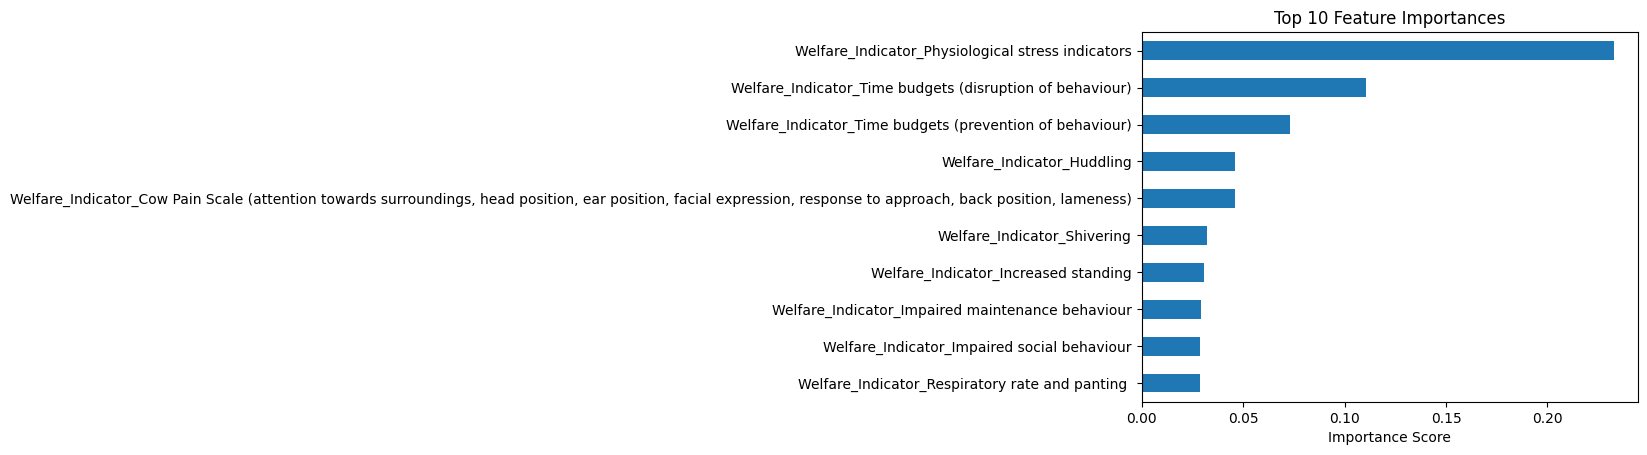

In [125]:
# Optional: Plot Feature Importances
importances_sorted.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

## principal component Analysis

In [126]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

# Data Cleaning
df['Welfare_Indicator'] = df['Welfare_Indicator'].str.replace('Coat condiition', 'Coat condition', regex=False)
categorical_columns = ['Species', 'Animal_Class', 'Welfare_Hazards_Animal',
                       'Welfare_Hazards_Consequences', 'Welfare_Hazards_Impact',
                       'Ease_of_Hazard_Mitigation', 'Welfare_Indicator',
                       'Indicator_Ease', 'Indicator_Resources']

for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip()

# Encode categorical variables
encoder = OneHotEncoder(drop='first')
X = encoder.fit_transform(df[['Welfare_Indicator']]).toarray()
indicator_names = encoder.get_feature_names_out(['Welfare_Indicator'])
X = pd.DataFrame(X, columns=indicator_names)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components to retain 95% variance: {pca.n_components_}")

# Examine loadings
loadings = pd.DataFrame(pca.components_.T, index=indicator_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
print("\nPCA Loadings:")
print(loadings)



Number of components to retain 95% variance: 50

PCA Loadings:
                                                         PC1       PC2  \
Welfare_Indicator_Agonistic behaviour              -0.028058 -0.006687   
Welfare_Indicator_Agonistic interactions           -0.028058 -0.006687   
Welfare_Indicator_Allo-grooming                    -0.028058 -0.006687   
Welfare_Indicator_Altered resting posture          -0.028058 -0.006687   
Welfare_Indicator_Amount of eye white              -0.040807 -0.010181   
Welfare_Indicator_Body condition scoring           -0.061213 -0.017029   
Welfare_Indicator_Brush use                        -0.028058 -0.006687   
Welfare_Indicator_Calving behaviour (difficult/... -0.028058 -0.006687   
Welfare_Indicator_Calving records (death of cow)   -0.051447 -0.013510   
Welfare_Indicator_Calving records (difficulty c... -0.028058 -0.006687   
Welfare_Indicator_Calving records (duration of ... -0.028058 -0.006687   
Welfare_Indicator_Coat condition / cleanliness   


Top 4 Indicators based on PCA loadings:
['Welfare_Indicator_Calving records (difficulty calving)', 'Welfare_Indicator_Speed', 'Welfare_Indicator_Teat disorders', 'Welfare_Indicator_Deviation from normal, uninterrupted getting up movement']


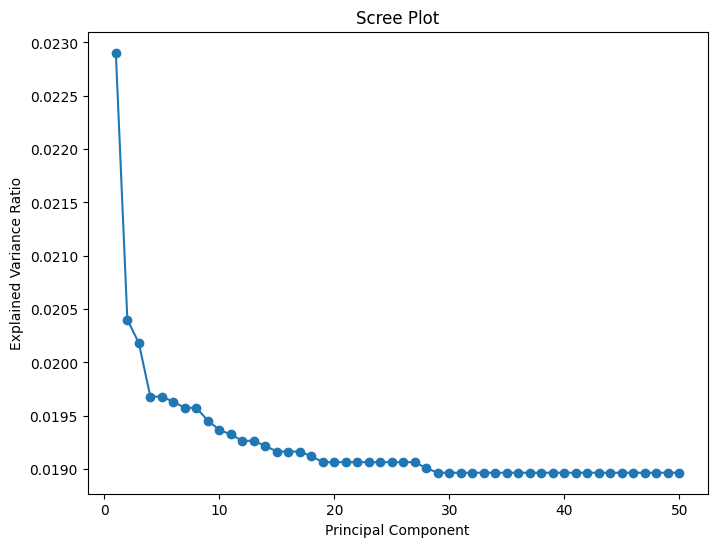

In [127]:
# Select indicators with highest absolute loadings on the first few PCs
top_indicators = loadings.abs().sum(axis=1).sort_values(ascending=False).head(4).index.tolist()
print("\nTop 4 Indicators based on PCA loadings:")
print(top_indicators)

# Optional: Scree Plot
plt.figure(figsize=(8,6))
plt.plot(range(1, len(pca.explained_variance_ratio_) +1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()


## linear modeling

In [128]:
categorical_columns = [
    'Species', 'Animal_Class', 'Welfare_Hazards_Animal',
    'Welfare_Hazards_Consequences', 'Welfare_Hazards_Impact',
    'Ease_of_Hazard_Mitigation', 'Welfare_Indicator',
    'Indicator_Ease', 'Indicator_Resources'
]

for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip()

# Verify unique categories
print("\nUnique Welfare Indicators:", df['Welfare_Indicator'].unique())
print("Number of Unique Welfare Indicators:", df['Welfare_Indicator'].nunique())




Unique Welfare Indicators: ['Abdominal discomfort' 'Agonistic behaviour' 'Agonistic interactions'
 'Allo-grooming' 'Altered resting posture' 'Amount of eye white'
 'Body condition scoring' 'Brush use'
 'Calving behaviour (difficult/long calving)'
 'Calving records (death of cow)' 'Calving records (difficulty calving)'
 'Calving records (duration of calving)' 'Coat condition / cleanliness'
 'Cow Pain Scale (attention towards surroundings, head position, ear position, facial expression, response to approach, back position, lameness)'
 'Deviation from normal, uninterrupted getting up movement' 'Disease'
 'Distended udder' 'Duration of lying down movement'
 'Frequency of lying bouts' 'Gait assessment' 'Hock alterations'
 'Hot, red, painful udder' 'Huddling' 'Impaired calving behavour'
 'Impaired maintenance behaviour' 'Impaired social behaviour'
 'Increased standing' 'Injuries' 'Knee alterations' 'Lesions of the claw'
 'Locomotory behaviour (restricted movement)'
 'Lying behaviour synchro

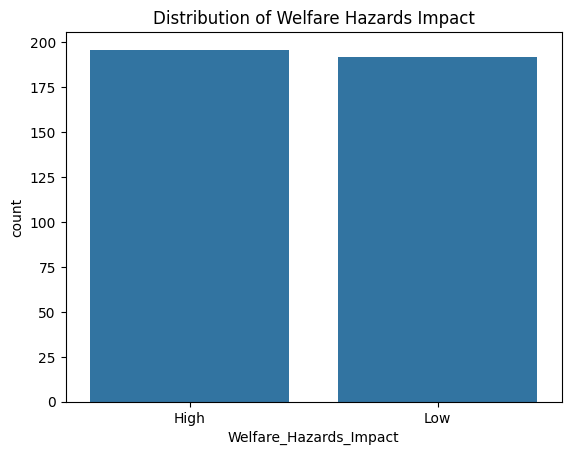

In [96]:
import seaborn as sns
# Visualize the distribution of the target variable
sns.countplot(data=df, x='Welfare_Hazards_Impact')
plt.title('Distribution of Welfare Hazards Impact')
plt.show()

In [129]:
# Define the target variable
target = 'Welfare_Hazards_Impact'

# Encode the target variable as ordinal
# Assuming 'Low' < 'Moderate' < 'High'
target_mapping = {'Low': 0,  'High': 1}
df[target] = df[target].map(target_mapping)

# Check for any missing values in the target
print("\nMissing values in target:", df[target].isna().sum())

# Select predictor variables (excluding ID and the target)
predictors = [
    'Species', 'Animal_Class', 'Welfare_Hazards_Animal',
    'Welfare_Hazards_Consequences', 'Ease_of_Hazard_Mitigation',
    'Welfare_Indicator', 'Indicator_Ease', 'Indicator_Resources'
]

# Create a new DataFrame for modeling
model_df = df[predictors + [target]].copy()

# Convert categorical variables into dummy variables
# We'll drop the first category to avoid multicollinearity
model_df_encoded = pd.get_dummies(model_df, columns=predictors, drop_first=True)

# Display the first few rows of the encoded DataFrame
print("\nEncoded DataFrame:")
model_df_encoded.head()



Missing values in target: 0

Encoded DataFrame:


,Welfare_Hazards_Impact,Animal_Class_Tie stalls,Welfare_Hazards_Animal_Being tied without exercise for long periods,Welfare_Hazards_Animal_Continuous housing for long periods,Welfare_Hazards_Animal_Delayed calving intervention,Welfare_Hazards_Animal_Difficulty calving because of the sire,Welfare_Hazards_Animal_Early separation of cow and calf,Welfare_Hazards_Animal_Early separation of cow and calf (after 24h),Welfare_Hazards_Animal_Excessive noise (constant or sudden),Welfare_Hazards_Animal_Fewer cubicles than cows,...,Welfare_Indicator_Time budgets (prevention of behaviour),Welfare_Indicator_Time budgets (reduced behavioural repertoire),Welfare_Indicator_Time spent looking out of pen,Welfare_Indicator_Vocalisations,Welfare_Indicator_Walking distance,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves),Indicator_Ease_Easy,Indicator_Ease_Moderate,Indicator_Resources_Low,Indicator_Resources_Medium
0,1,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,0,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
3,0,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
4,1,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


In [130]:
welfare_indicator_dummies = [col for col in model_df_encoded.columns if 'Welfare_Indicator_' in col]


In [131]:
other_dummies = [col for col in model_df_encoded.columns if col not in welfare_indicator_dummies and col != target]

other_dummies

['Animal_Class_Tie stalls',
 'Welfare_Hazards_Animal_Being tied without exercise for long periods',
 'Welfare_Hazards_Animal_Continuous housing for long periods',
 'Welfare_Hazards_Animal_Delayed calving intervention',
 'Welfare_Hazards_Animal_Difficulty calving because of the sire',
 'Welfare_Hazards_Animal_Early separation of cow and calf',
 'Welfare_Hazards_Animal_Early separation of cow and calf (after 24h)',
 'Welfare_Hazards_Animal_Excessive noise (constant or sudden)',
 'Welfare_Hazards_Animal_Fewer cubicles than cows',
 'Welfare_Hazards_Animal_Inadequate bedding (cubicle/stall floor)',
 'Welfare_Hazards_Animal_Inadequate design of waiting area (size, flooring, crowding gates)',
 'Welfare_Hazards_Animal_Inadequate flooring in passageways, feeding and milking areas',
 'Welfare_Hazards_Animal_Inadequate housing design',
 'Welfare_Hazards_Animal_Inadequate maintenance of housing',
 'Welfare_Hazards_Animal_Inadequate maintenance of milking equipment',
 'Welfare_Hazards_Animal_Inadeq

In [132]:
for wi in welfare_indicator_dummies:
    for od in other_dummies:
        interaction_term = f"{wi}_x_{od}"
        model_df_encoded[interaction_term] = model_df_encoded[wi] * model_df_encoded[od]


/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_88144/1302222147.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_df_encoded[interaction_term] = model_df_encoded[wi] * model_df_encoded[od]
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_88144/1302222147.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_df_encoded[interaction_term] = model_df_encoded[wi] * model_df_encoded[od]
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_88144/1302222147.py:4: PerformanceWarning: DataFrame is h

In [133]:
model_df_encoded.head()

,Welfare_Hazards_Impact,Animal_Class_Tie stalls,Welfare_Hazards_Animal_Being tied without exercise for long periods,Welfare_Hazards_Animal_Continuous housing for long periods,Welfare_Hazards_Animal_Delayed calving intervention,Welfare_Hazards_Animal_Difficulty calving because of the sire,Welfare_Hazards_Animal_Early separation of cow and calf,Welfare_Hazards_Animal_Early separation of cow and calf (after 24h),Welfare_Hazards_Animal_Excessive noise (constant or sudden),Welfare_Hazards_Animal_Fewer cubicles than cows,...,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Welfare_Hazards_Consequences_Restriction of movement,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Welfare_Hazards_Consequences_Separation stress,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Welfare_Hazards_Consequences_Skin disorders (other than soft tissue lesions and integument damage),Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Welfare_Hazards_Consequences_Soft tissue lesions and integument damage,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Ease_of_Hazard_Mitigation_Easy,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Ease_of_Hazard_Mitigation_Moderate,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Indicator_Ease_Easy,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Indicator_Ease_Moderate,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Indicator_Resources_Low,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)_x_Indicator_Resources_Medium
0,1,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [134]:
X = model_df_encoded.drop(columns=[target])
y = model_df_encoded[target]


In [135]:
X = sm.add_constant(X)

In [137]:
# Identify boolean columns in X
bool_cols = X.columns[X.dtypes == 'bool'].tolist()
print("\nBoolean Columns in X:", bool_cols)

# Convert boolean columns to integers
for col in bool_cols:
    X[col] = X[col].astype(int)

# Verify the conversion
print("\nData Types of X after conversion:")
print(X.dtypes)


Boolean Columns in X: ['Animal_Class_Tie stalls', 'Welfare_Hazards_Animal_Being tied without exercise for long periods', 'Welfare_Hazards_Animal_Continuous housing for long periods', 'Welfare_Hazards_Animal_Delayed calving intervention', 'Welfare_Hazards_Animal_Difficulty calving because of the sire', 'Welfare_Hazards_Animal_Early separation of cow and calf', 'Welfare_Hazards_Animal_Early separation of cow and calf (after 24h)', 'Welfare_Hazards_Animal_Excessive noise (constant or sudden)', 'Welfare_Hazards_Animal_Fewer cubicles than cows', 'Welfare_Hazards_Animal_Inadequate bedding (cubicle/stall floor)', 'Welfare_Hazards_Animal_Inadequate design of waiting area (size, flooring, crowding gates)', 'Welfare_Hazards_Animal_Inadequate flooring in passageways, feeding and milking areas', 'Welfare_Hazards_Animal_Inadequate housing design', 'Welfare_Hazards_Animal_Inadequate maintenance of housing', 'Welfare_Hazards_Animal_Inadequate maintenance of milking equipment', 'Welfare_Hazards_Anima

In [138]:
model = sm.OLS(y, X).fit()

In [139]:
print("\nLinear Regression Model Summary:")
print(model.summary())



Linear Regression Model Summary:
                              OLS Regression Results                              
Dep. Variable:     Welfare_Hazards_Impact   R-squared:                       1.000
Model:                                OLS   Adj. R-squared:                  1.000
Method:                     Least Squares   F-statistic:                 1.095e+29
Date:                    Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                            12:47:31   Log-Likelihood:                 12777.
No. Observations:                     388   AIC:                        -2.508e+04
Df Residuals:                         151   BIC:                        -2.414e+04
Df Model:                             236                                         
Covariance Type:                nonrobust                                         
                                                                                                                                        

In [140]:
significant_interactions = model.pvalues[model.pvalues < 0.05].index.tolist()
significant_interactions = [term for term in significant_interactions if '_x_' in term]

print("\nSignificant Interaction Terms:")
print(significant_interactions)



Significant Interaction Terms:
['Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Being tied without exercise for long periods', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Continuous housing for long periods', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Delayed calving intervention', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Difficulty calving because of the sire', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Early separation of cow and calf', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Early separation of cow and calf (after 24h)', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Excessive noise (constant or sudden)', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Fewer cubicles than cows', 'Welfare_Indicator_Agonistic behaviour_x_Welfare_Hazards_Animal_Inadequate bedding (cubicle/stall floor)', 'Welfare_Indicator_Agonistic behaviour_x_We

/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_88144/2871448630.py:10: FutureWarning: The provided callable <function mean at 0x111fbc400> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.pivot_table(model_df_encoded, values=target, index=wi, columns=od, aggfunc=np.mean)


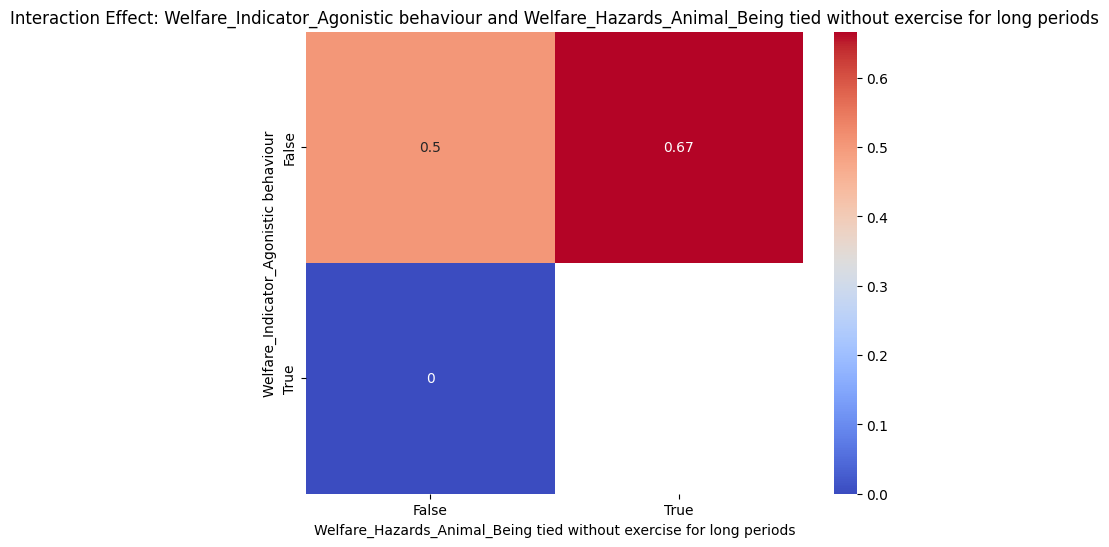

In [141]:
# Example: Plotting one significant interaction
if significant_interactions:
    # Choose the first significant interaction for plotting
    interaction = significant_interactions[0]
    
    # Extract the two interacting variables
    wi, od = interaction.split('_x_')
    
    # Create a pivot table
    pivot = pd.pivot_table(model_df_encoded, values=target, index=wi, columns=od, aggfunc=np.mean)
    
    # Plot the pivot table as a heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, cmap='coolwarm')
    plt.title(f'Interaction Effect: {wi} and {od}')
    plt.xlabel(od)
    plt.ylabel(wi)
    plt.show()
else:
    print("No significant interaction terms to visualize.")

In [142]:
pivot = pd.pivot_table(model_df_encoded, values=target, index=wi, columns=od, aggfunc=np.mean)

/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_88144/2703944740.py:1: FutureWarning: The provided callable <function mean at 0x111fbc400> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.pivot_table(model_df_encoded, values=target, index=wi, columns=od, aggfunc=np.mean)


In [143]:
pivot

Welfare_Hazards_Animal_Being tied without exercise for long periods,False,True
Welfare_Indicator_Agonistic behaviour,,
False,0.502674,0.666667
True,0.000000,NaN
